# Predicting likelihood of job automation

### Libraries and functions

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import (RBF,RationalQuadratic)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Manual bucketing

def prob_classification(x):
    if x < 0.3:
        return "3) Low"
    elif x < 0.6:
        return "2) Medium"
    else:
        return "1) High"

### Read data

In [3]:
ML_data_2010 = pd.read_csv("ML_data_2010.csv") 
ML_data_2018 = pd.read_csv("ML_data_2018.csv")
ML_data_2010['year'] = 2010
ML_data_2018['year'] = 2018
print(ML_data_2010.shape)
print(ML_data_2018.shape)

(716, 14)
(774, 15)


In [4]:
jobs_concat = pd.concat([ML_data_2010,ML_data_2018], axis=0, ignore_index=True, sort=False)

### EDA

In [5]:
jobs_concat[jobs_concat.year == 2010].describe()

fine_arts  finger_dexterity  manual_dexterity  social_perceptiveness  \
count  716.000000        716.000000        716.000000             716.000000   
mean     0.547839          2.736508          2.226033               2.987409   
std      0.963295          0.662948          1.144053               0.649236   
min      0.000000          0.500000          0.000000               0.330000   
25%      0.050000          2.380000          1.500000               2.500000   
50%      0.210000          2.750000          2.620000               2.880000   
75%      0.561250          3.130000          3.120000               3.380000   
max      6.520000          5.120000          5.250000               5.880000   

       Negotiation  Originality  Persuasion  assisting_and_caring  \
count   716.000000   716.000000  716.000000            716.000000   
mean      2.517483     2.742966    2.712802              2.841640   
std       0.685865     0.778983    0.696622              1.177327   
min       0.830000     0.000000    0.880000              0.270000   
25%       2.000000     2.130000    2.120000              2.017500   
50%       2.500000     2.750000    2.620000              2.540000   
75%       3.000000     3.298750    3.250000              3.420000   
max       5.000000     5.500000    5.000000              6.590000   

       cramped_work_space   label_ML  probability_ML    year  \
count          716.000000  68.000000      693.000000   716.0   
mean             2.124754   0.573529        0.538476  2010.0   
std              0.837110   0.498241        0.368785     0.0   
min              1.000000   0.000000        0.002800  2010.0   
25%              1.467500   0.000000        0.110000  2010.0   
50%              1.895000   1.000000        0.640000  2010.0   
75%              2.622500   1.000000        0.890000  2010.0   
max              4.900000   1.000000        0.990000  2010.0   

       cognitive_abilities  physical_abilities  psychomotor_abilities  \
count                  0.0                 0.0                    0.0   
mean                   NaN                 NaN                    NaN   
std                    NaN                 NaN                    NaN   
min                    NaN                 NaN                    NaN   
25%                    NaN                 NaN                    NaN   
50%                    NaN                 NaN                    NaN   
75%                    NaN                 NaN                    NaN   
max                    NaN                 NaN                    NaN   

       sensory_abilities  
count                0.0  
mean                 NaN  
std                  NaN  
min                  NaN  
25%                  NaN  
50%                  NaN  
75%                  NaN  
max                  NaN

In [6]:
jobs_concat.groupby(['year']).mean()

fine_arts  finger_dexterity  manual_dexterity  social_perceptiveness  \
year                                                                         
2010   0.547839          2.736508          2.226033               2.987409   
2018   0.620393          2.564126          2.144432               3.045887   

      Negotiation  Originality  Persuasion  assisting_and_caring  \
year                                                               
2010     2.517483     2.742966    2.712802              2.841640   
2018     2.500646     2.792373    2.707839              2.927762   

      cramped_work_space  label_ML  probability_ML  cognitive_abilities  \
year                                                                      
2010            2.124754  0.573529        0.538476                  NaN   
2018            2.048272       NaN             NaN             2.673901   

      physical_abilities  psychomotor_abilities  sensory_abilities  
year                                                                
2010                 NaN                    NaN                NaN  
2018            1.259155               1.751971           2.009712

In [7]:
occ_tracking = jobs_concat[['OCC_CODE','year']].groupby(['OCC_CODE']).sum()
occ_tracking['job_span'] = ['2018 only' if a==2018 else '2010 only' if a==2010 else 'Both' for a in occ_tracking.year]
occ_tracking.drop(['year'], axis=1, inplace=True)
jobs_concat = jobs_concat.merge(occ_tracking, on = 'OCC_CODE')

In [8]:
jobs_concat.groupby(['year','job_span']).mean()

fine_arts  finger_dexterity  manual_dexterity  \
year job_span                                                   
2010 Both        0.547839          2.736508          2.226033   
2018 2018 only   0.936924          1.837883          1.275188   
     Both        0.588920          2.636337          2.230863   

                social_perceptiveness  Negotiation  Originality  Persuasion  \
year job_span                                                                 
2010 Both                    2.987409     2.517483     2.742966    2.712802   
2018 2018 only               3.553705     2.773819     3.259821    3.018062   
     Both                    2.995394     2.473484     2.745894    2.676993   

                assisting_and_caring  cramped_work_space  label_ML  \
year job_span                                                        
2010 Both                   2.841640            2.124754  0.573529   
2018 2018 only              3.653176            1.529679       NaN   
     Both                   2.855633            2.099836       NaN   

                probability_ML  cognitive_abilities  physical_abilities  \
year job_span                                                             
2010 Both             0.538476                  NaN                 NaN   
2018 2018 only             NaN             2.825477            0.717723   
     Both                  NaN             2.658829            1.312990   

                psychomotor_abilities  sensory_abilities  
year job_span                                             
2010 Both                         NaN                NaN  
2018 2018 only               0.953845           1.793726  
     Both                    1.831330           2.031187

In [9]:
new_jobs = jobs_concat[jobs_concat.job_span == '2018 only']

### Modelling

In [10]:
# Filter 2010 data for ~70 hand-labelled careers
# Create training and label sets

hand_labels_train = jobs_concat[jobs_concat.label_ML >=0]
features = ['fine_arts','finger_dexterity','manual_dexterity','social_perceptiveness','Negotiation','Originality','Persuasion','assisting_and_caring','cramped_work_space']
X_train = hand_labels_train[features]
y_train = hand_labels_train[['label_ML']]

In [11]:
# Train model on hand labels

#kernel = 1.0 * RBF(1.0)
kernel = 1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train, y_train)
gpc.score(X_train, y_train)

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9558823529411765

### Run model across occupations

In [12]:
X_all = jobs_concat[features]
GP_pred = pd.DataFrame(gpc.predict_proba(X_all))
jobs_output = pd.concat([jobs_concat,GP_pred],axis=1,ignore_index= True)
jobs_output.columns = jobs_concat.columns.tolist() + ['GP_pred_0','GP_pred_1']

In [13]:
jobs_output.head(10)

OCC_CODE                            OCC_TITLE  fine_arts  finger_dexterity  \
0  11-1011                     Chief Executives      0.290              2.13   
1  11-1011                                  NaN      0.915              2.00   
2  11-1021      General and Operations Managers      0.060              2.75   
3  11-1021                                  NaN      0.470              1.38   
4  11-2011  Advertising and Promotions Managers      3.510              1.75   
5  11-2011                                  NaN      2.300              1.12   
6  11-2021                   Marketing Managers      1.520              1.75   
7  11-2021                                  NaN      1.320              1.25   
8  11-2022                       Sales Managers      0.500              2.12   
9  11-2022                                  NaN      0.610              1.25   

   manual_dexterity  social_perceptiveness  Negotiation  Originality  \
0              0.00                  4.380        4.500        4.500   
1              0.00                  3.935        3.935        4.125   
2              2.25                  3.620        3.500        3.250   
3              0.75                  4.000        3.620        3.380   
4              0.62                  3.750        3.750        3.750   
5              0.38                  4.000        3.750        3.880   
6              0.00                  4.120        4.000        4.000   
7              0.00                  4.000        3.880        4.000   
8              1.62                  4.250        3.880        4.120   
9              0.62                  4.120        3.880        3.880   

   Persuasion  assisting_and_caring  ...  label_ML  probability_ML  year  \
0        5.00                 2.420  ...       0.0           0.015  2010   
1        4.44                 2.275  ...       NaN             NaN  2018   
2        3.50                 3.600  ...       NaN           0.160  2010   
3        3.50                 2.950  ...       NaN             NaN  2018   
4        3.62                 1.910  ...       NaN           0.039  2010   
5        3.88                 2.000  ...       NaN             NaN  2018   
6        4.25                 2.440  ...       NaN           0.014  2010   
7        4.38                 2.210  ...       NaN             NaN  2018   
8        4.25                 2.300  ...       NaN           0.013  2010   
9        4.38                 2.610  ...       NaN             NaN  2018   

   cognitive_abilities  physical_abilities  psychomotor_abilities  \
0                  NaN                 NaN                    NaN   
1             3.242865            0.013889                  0.456   
2                  NaN                 NaN                    NaN   
3             3.026486            1.026667                  1.137   
4                  NaN                 NaN                    NaN   
5             2.799027            0.097778                  0.287   
6                  NaN                 NaN                    NaN   
7             2.882757            0.125556                  0.212   
8                  NaN                 NaN                    NaN   
9             2.958811            0.153333                  0.523   

   sensory_abilities  job_span GP_pred_0  GP_pred_1  
0                NaN      Both  0.955642   0.044358  
1           1.837083      Both  0.926849   0.073151  
2                NaN      Both  0.841758   0.158242  
3           1.928333      Both  0.859625   0.140375  
4                NaN      Both  0.869040   0.130960  
5           1.780833      Both  0.915966   0.084034  
6                NaN      Both  0.935665   0.064335  
7           1.792500      Both  0.929223   0.070777  
8                NaN      Both  0.964190   0.035810  
9           1.812500      Both  0.949928   0.050072  

[10 rows x 21 columns]

### Results on 2010 dataset

In [14]:
jobs_output['prob_class_old'] = jobs_output.probability_ML.apply(prob_classification)
jobs_output['prob_class_new'] = jobs_output.GP_pred_1.apply(prob_classification)
jobs_output.groupby(['prob_class_old','prob_class_new']).size()

prob_class_old  prob_class_new
1) High         1) High           685
                2) Medium         207
                3) Low            275
2) Medium       1) High            31
                2) Medium          43
                3) Low             16
3) Low          1) High             7
                2) Medium          41
                3) Low            185
dtype: int64

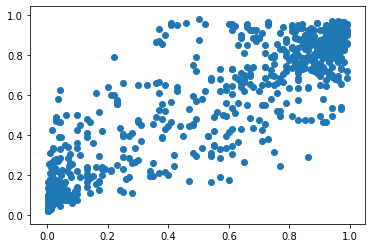

In [15]:
jobs_output_2010 = jobs_output[jobs_output.year == 2010]
plt.scatter(jobs_output_2010['probability_ML'], jobs_output_2010['GP_pred_1'])

# Shows my modelling is not perfectly aligned with researtch paper - but generally matches category

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Modelled likelihood of automation')]

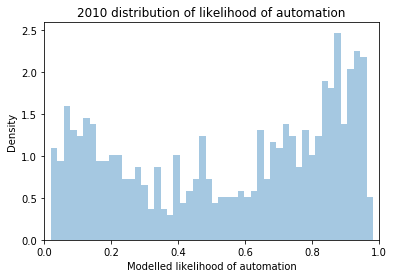

In [21]:
# 2010 distribution
ax = sns.distplot(jobs_output_2010.GP_pred_1, bins=50)
plt.xlim(0, 1)
ax.get_lines()[0].remove()
ax.set_title("2010 distribution of likelihood of automation")
ax.set(xlabel='Modelled likelihood of automation', ylabel='Density')

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Modelled likelihood of automation')]

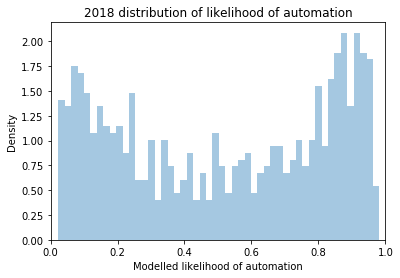

In [22]:
# 2018 distribution
jobs_output_2018 = jobs_output[jobs_output.year == 2018]
ax = sns.distplot(jobs_output_2018.GP_pred_1, bins=50)
plt.xlim(0, 1)
ax.get_lines()[0].remove()
ax.set_title("2018 distribution of likelihood of automation")
ax.set(xlabel='Modelled likelihood of automation', ylabel='Density')

## Output data

In [18]:
#ML_output_2018.to_csv('ML_output_2018.csv')